# Flow for $[0,1]^N$ games

In [204]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
from aspera import utils
import time

# --------------------------------------------------------
# Project-specific
# --------------------------------------------------------
current_directory = './results/3-player-zero-sum-2025-07-05'

# --------------------------------------------------------

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import itertools
from aspera import utils

# to write general code for arbitrary regularizer and game; now quick and dirty

In [207]:
import legendre
#import gamelab.finitegames as NormalFormGame
import sympy as sp

In [234]:
# Number of players
N = 3

---

In [235]:
triples = list(itertools.combinations(range(N), 3))  # Generate all triples of dimensions to plot
for triple in triples:
    print(triple)

(0, 1, 2)


In [236]:
# simvars = sp.symbols('x, y, z', positive=True)
simvars = sp.symbols(f'w1:{N+1}') 
x, y = sp.symbols('x, y', positive=True)

In [237]:
simvars

(w1, w2, w3)

## Kernels

In [238]:
#---------------------------------------------------------------------
# Define (symbolic) kernel functions andtheir labels
#---------------------------------------------------------------------

# 0 = sha
# 1 = log barrier
# 2 = q-replicator
# 3 = q-replicator

# q-replicator parameters
Q = [] # [0.5, 1.5] #, 2.5]



# Kiwiel kernel parameter; very similar to q-replicator
kiw = 0.5

# Teboulle kernel --> very similar to q-replicator

# sympy expressions
simkernels = [
    x * sp.log(x),
    (x**2 - x)/4,
    - (x**kiw) / kiw] + [(x - x**q) / ( 1-q ) for q in Q ]

# kernel labels
kerlabels = ["Sha", "Eu", "Kiw"] + [f"q = {q} Sha" for q in Q]
#---------------------------------------------------------------------

# simkernels = simkernel + [  - sp.log(x) ]
# reglabels = reglabels  + [ "log" ]

## Regularizers

In [239]:
#---------------------------------------------------------------------
# Define additional (symbolic) regularizer functions functions and their labels
#---------------------------------------------------------------------
#m
simregs = [] # [ x * sp.log(x) + (2/mi - x) * sp.log(2/mi - x) for mi in m] # [ 1/2 * sp.log(x-1) + - x * sp.atanh(1-2*x) ]
reglabels_tmp = [] # [f"(m={mi})-entropic" for mi in m] # [ "atanh" ]

In [240]:
for i, h in enumerate(simregs):
    print(reglabels_tmp[i], ":", h)

In [215]:
reglabels = kerlabels + reglabels_tmp

In [241]:
# Init Legendre class
A = legendre.LinFTRL(simkernels = simkernels, reglabels = reglabels, radius = 1, sim_manual_regularizers = simregs)

hello world!


In [242]:
for i, h in enumerate(A.simregularizers):
    print(i+1, ":", reglabels[i], ":", h)

1 : Sha : x*log(x) + (1 - x)*log(1 - x)
2 : Eu : x**2/4 + (1 - x)**2/4 - 1/4
3 : Kiw : -2.0*x**0.5 - 2.0*(1 - x)**0.5


## Continuous games

## Payoff of spherical games


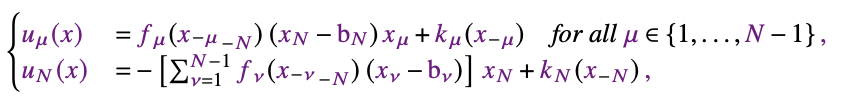

In [243]:
# Example: Any payoff function for a [0,1]^N game

w1, w2, w3 = simvars

#f1 = w2**3 + sp.sin(w2) 
#f2 = w1**2 * sp.cosh(w1)

f1 = 1
f2 = -1

f = [f1, f2]
effs = simvars[:-1]

In [244]:
## spherical
#sympayfield = [ f_mu * ( simvars[-1] - 0.5 ) for f_mu in f ] + [ -sum([ f[nu] * (effs[nu] - 0.5) for nu in range(len(effs)) ])  ]
#sympayfield = [ sp.simplify(v) for v in sympayfield  ]
#sp.Matrix(sympayfield)

In [220]:
# check spherical
#sp.simplify(sum( [ sympayfield[i] * (simvars[i]-0.5)  for i in range(N)] ))

### Other games: plug in generic payfield

In [248]:
#sympayfield = [-2*w2 - 2*w3 + 2, -2*w1 - 2*w3 + 2, -2*w1 - 2*w2 + 2]

In [249]:
sympayfield = [-2*w2*w3 + 2*w2 + 2*w3 - 1, 2*w1*w3 - 2*w1 - 2*w3 + 1, 1 - 2*w1]

In [250]:
payfield = sp.lambdify(simvars, sympayfield)

In [252]:
sympayfield

[-2*w2*w3 + 2*w2 + 2*w3 - 1, 2*w1*w3 - 2*w1 - 2*w3 + 1, 1 - 2*w1]

## Dynamics

## Initial points

In [253]:
# init_generator = np.linspace(epsilon, 1-epsilon, 3)
init_generator = np.array( [   ] )

initial_points = [ p for p in itertools.product(init_generator, repeat = N) ]  + [ (0.2, 0.6, 0.7), (0.2, 0.3, 0.7), (0.1, 0.8, 0.7), (0.4, 0.9, 0.2) ] + [np.random.rand(3) for _ in range(5)]
initial_points

[(0.2, 0.6, 0.7),
 (0.2, 0.3, 0.7),
 (0.1, 0.8, 0.7),
 (0.4, 0.9, 0.2),
 array([0.33508614, 0.1927068 , 0.20814698]),
 array([0.46928248, 0.55383658, 0.73444409]),
 array([0.18466442, 0.12159711, 0.70400992]),
 array([0.31765494, 0.78692871, 0.88571917]),
 array([0.11698425, 0.06443995, 0.56614476])]

### Dual Averaging

In [226]:
def da(var, time, sharp, payfield):
        
    #x1, x2, x3 = var
    #V1, V2, V3 = payfield(x1, x2, x3)
        
    #F1 = sharp(x1) * V1
    #F2 = sharp(x2) * V2
    #F3 = sharp(x3) * V3
        
    return [ sharp( var[i] ) * payfield(*var)[i] for i in range(len(var)) ]

In [227]:
for i, sh in enumerate(A.simsharps):
    print(reglabels[i], ":", sh)

Sha : x*(1 - x)
Eu : 1
Kiw : 2.0*x**1.5*(1 - x)**1.5/(x**1.5 + (1 - x)**1.5)


In [256]:
# eg: Entropic regularizer
[da( p, 0, A.sharps[0], payfield ) for p in initial_points]

[[0.12159999999999999, -0.1248, 0.126],
 [0.0928, -0.1092, 0.126],
 [0.07920000000000002, -0.07359999999999998, 0.16800000000000004],
 [0.20159999999999995, -0.0036000000000000025, 0.032],
 [-0.06205412047679024, 0.008249628687400397, 0.05436280393069786],
 [0.1900393581234178, -0.1774510030546922, 0.011982042192338022],
 [0.07227090532280778, -0.05525746923620232, 0.13141922740371534],
 [0.20619455510415963, -0.14152215334513804, 0.036914197823168654],
 [0.019441349605684964, -0.014095082597237374, 0.18815638690856257]]

## Experiments

In [255]:
# Set the same aspect ratio for all axes
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres look like spheres, cubes like cubes.'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [258]:
def make_plots(sharp_index, payfield, initial_points, time, name, plot_point = False, special_point = 0, dims_to_plot = [0,1,2]):
    
    # Solve ODE
    sols = [ odeint(da, p, time, args=(A.sharps[sharp_index], payfield)) for p in initial_points ]

    fig = plt.figure(figsize = (8,8) )
    ax = fig.add_subplot(111, projection='3d')

    dim_x, dim_y, dim_z = dims_to_plot

    # Draw cube edges
    for s, e in [
        ((0, 0, 0), (1, 0, 0)),
        ((0, 0, 0), (0, 1, 0)),
        ((0, 0, 0), (0, 0, 1)),
        ((1, 1, 0), (1, 0, 0)),
        ((1, 1, 0), (0, 1, 0)),
        ((1, 1, 0), (1, 1, 1)),
        ((0, 1, 1), (0, 1, 0)),
        ((0, 1, 1), (0, 0, 1)),
        ((0, 1, 1), (1, 1, 1)),
        ((1, 0, 1), (1, 0, 0)),
        ((1, 0, 1), (0, 0, 1)),
        ((1, 0, 1), (1, 1, 1)),
    ]:
        ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], 'k-', lw=1)
    
    # Plot trajectories
    for sol in sols:
        x, y, z = sol[:, dim_x], sol[:, dim_y], sol[:, dim_z]
        ax.plot(x, y, z, color = 'blue', linewidth=0.5)

    # Quiver initial vector
    initial_vectors = [ da(p, 0, A.sharps[sharp_index], payfield ) for p in initial_points ]
    
    x_quiver, y_quiver, z_quiver = utils.coords_points(initial_points)
    dx_quiver, dy_quiver, dz_quiver = utils.coords_points(initial_vectors)
    
    ax.quiver(x_quiver, y_quiver, z_quiver, dx_quiver, dy_quiver, dz_quiver, color='blue')
        
   
    
    ax.set_xlabel("Player 1's strategy")
    ax.set_ylabel("Player 2's strategy")
    ax.set_zlabel("Player 3's strategy", labelpad=-2)  # Increase padding for the z-label
    plt.tight_layout()

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    #ax.set_title(f"{name} - {A.reglabels[sharp_index]} - Plotting {dims_to_plot}")
    #set_axes_equal(ax)

    # scatter initial conditions
    [ax.plot(*[p[i] for i in dims_to_plot], 'bo', ms = 3) for p in initial_points ]

    if plot_point:
        ax.plot(*special_point, "ko")
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Set viewpoint: close to equator
    ax.view_init(elev=18, azim=-35)
    

    #plt.tight_layout()
    #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    ## Saving
    #utils.make_folder(current_directory)
    #plt.savefig(f'{current_directory}/{name}.pdf', bbox_inches='tight')#, pad_inches = 0)
    plt.show()
        
    

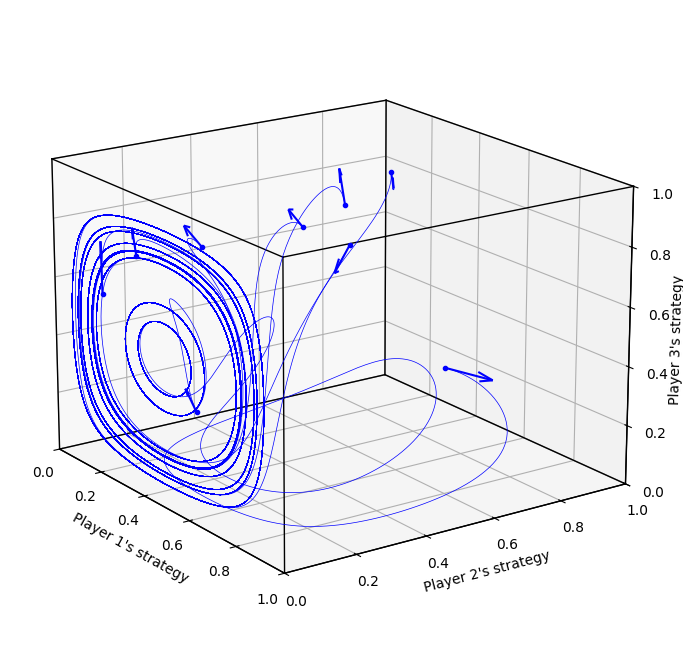

In [260]:
# Plot
time_series = np.linspace(1, 1000, 10000)

# Triples = dims to plot (in case plotting more than 3d)
for triple in triples:
    make_plots(sharp_index = 0, payfield = payfield, initial_points = initial_points, time = time_series, name = "3PZS"+str(time.time()), dims_to_plot = triple)